In [1]:
import numpy as np
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Activation
from keras.layers import Input
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


# Parameters

In [2]:
num_class = 10
dim_class = 16
input_shape = (28, 28, 1)

batch_size = 32

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

# Model

## Reconstruction

In [4]:
reconstruction_input = Input(shape=(num_class * dim_class,))

reconstruction_layer = Dense(512, activation='relu') (reconstruction_input)
reconstruction_layer = Dense(1024, activation='relu') (reconstruction_layer)
reconstruction_layer = Dense(784, activation='sigmoid') (reconstruction_layer)
reconstruction_layer = Reshape((input_shape), name='reconstruction') (reconstruction_layer)

model_reconstruction = Model(inputs=reconstruction_input, outputs=reconstruction_layer)

## Capsule

In [5]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=256, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=num_class, capsule_dim=dim_class, routings=3, activation_caps=squash) (encoder)

model = Model(inputs=x, outputs=encoder)

## Training model

In [6]:
output = ClassesCaps() (encoder)
output = Activation('softmax', name='capsule') (output)

decoder = Mask() (encoder, y_true=y)
decoder = model_reconstruction(decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 256)       20992     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 1152, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            1474560   
Total params: 6,804,224
Trainable params: 6,804,224
Non-trainable params: 0
_________________________________________________________________


# Training

In [16]:
model_training.compile(loss=['mse', mean_squared_error],
                        loss_weights=[1, 0.01],
                        optimizer=Adam(lr=3e-4),
                        metrics={'capsule': 'accuracy'})

In [17]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=60000 // batch_size,
                                    epochs=1,
                                    validation_data=testGenerator,
                                    validation_steps=10000 // batch_size,
                                    verbose=2,
                                    callbacks=[history])

Epoch 1/1
 - 398s - loss: 0.0679 - capsule_loss: 0.0673 - model_1_loss: 0.0596 - capsule_acc: 0.9764 - val_loss: 0.0671 - val_capsule_loss: 0.0666 - val_model_1_loss: 0.0537 - val_capsule_acc: 0.9853


In [10]:
#plotHistory(history.metrics)

# Visualization

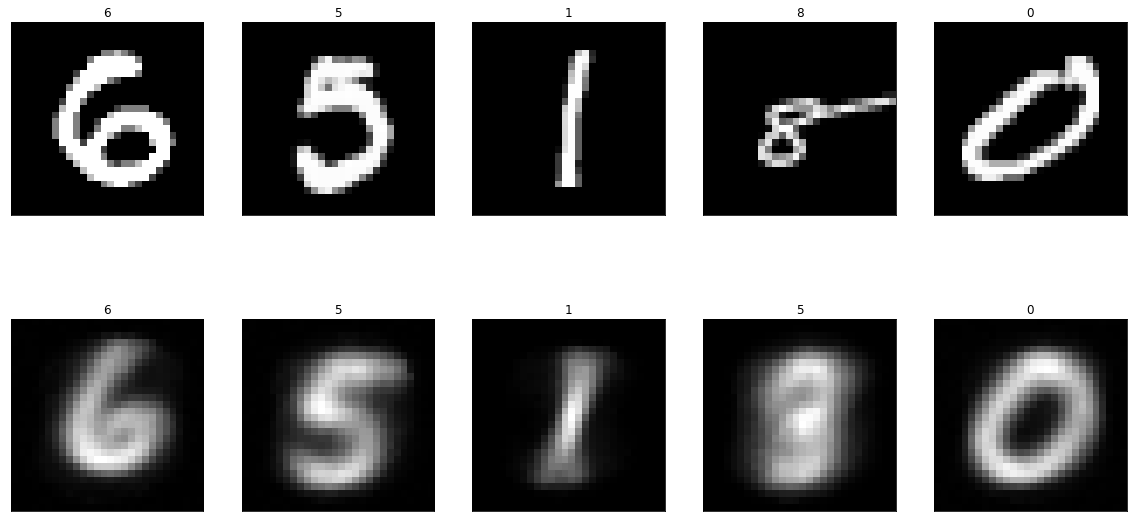

In [18]:
n_image = 5

# Select data
images, labels = next(dataGenerator('test', batch_size=n_image, reshape=False))

# Run inference
classes, reconstructions = model_training.predict([images, labels])

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)
images = images.reshape(-1, 28, 28)
reconstructions = reconstructions.reshape(-1, 28, 28)

visualization((images, labels), (reconstructions, predictions))

In [22]:
model_training.save_weights('model_train.h5')

# Bla

In [12]:
from matplotlib import pyplot as plt

In [23]:
# Select image
images, labels = next(dataGenerator('test', batch_size=1, reshape=False))

# Run inference
features = model.predict(images)

*Modify features*

In [91]:
features[0, 1] = [ 0.00051886,  1.50057969,  0.00043212,  0.0006002 ,  0.0004508 ,
       -0.00056749, -0.0005516 ,  0.00052007,  0.00046944,  0.00062095,
        0.00051013,  0.0005336 , -0.00052906, -0.00032854, -0.00045141,
        0.00049433]

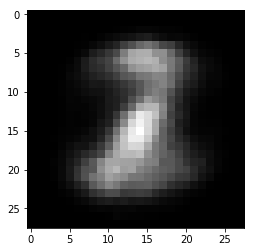

In [92]:
generated_image = model_reconstruction.predict(np.reshape(features, (1, -1)))[0]
_ = plt.imshow(generated_image.reshape(28, 28), cmap='gray')

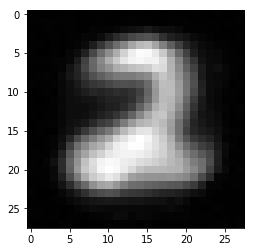

In [40]:
_ = plt.imshow(generated_image.reshape(28, 28), cmap='gray')